In [98]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
from hessians_calc import *
from demo_parity_calc import *
import copy

In [99]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital', 'occupation','relationship', 'race', 'gender', 'capgain', 'caploss', 'hours', 'country', 'income']

In [100]:
def process_adult(df):
    # replace missing values (?) to nan and then drop the columns
    df['country'] = df['country'].replace(' ?',np.nan)
    df['workclass'] = df['workclass'].replace(' ?',np.nan)
    df['occupation'] = df['occupation'].replace(' ?',np.nan)
    # dropping the NaN rows now
    df.dropna(how='any',inplace=True)
    df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1}).astype(int)
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['workclass'] = df['workclass'].map({' Never-worked': 0, ' Without-pay': 1, ' State-gov': 2, ' Local-gov': 3, ' Federal-gov': 4, ' Self-emp-inc': 5, ' Self-emp-not-inc': 6, ' Private': 7}).astype(int)
    df['education'] = df['education'].map({' Preschool': 0, ' 1st-4th': 1, ' 5th-6th': 2, ' 7th-8th': 3, ' 9th': 4, ' 10th': 5, ' 11th': 6, ' 12th': 7, ' HS-grad':8, ' Some-college': 9, ' Bachelors': 10, ' Prof-school': 11, ' Assoc-acdm': 12, ' Assoc-voc': 13, ' Masters': 14, ' Doctorate': 15}).astype(int)
    df['marital'] = df['marital'].map({' Married-civ-spouse': 2, ' Divorced': 1, ' Never-married': 0, ' Separated': 1, ' Widowed': 1, ' Married-spouse-absent': 2, ' Married-AF-spouse': 2}).astype(int)
    df['relationship'] = df['relationship'].map({' Wife': 1 , ' Own-child': 0 , ' Husband': 1, ' Not-in-family': 0, ' Other-relative': 0, ' Unmarried': 0}).astype(int)
    df['race'] = df['race'].map({' White': 1, ' Asian-Pac-Islander': 0, ' Amer-Indian-Eskimo': 0, ' Other': 0, ' Black': 0}).astype(int)
    df['gender'] = df['gender'].map({' Male': 1, ' Female': 0}).astype(int)
    # process hours
    df.loc[(df['hours'] <= 40), 'hours'] = 0
    df.loc[(df['hours'] > 40), 'hours'] = 1
    df = df.drop(columns=['fnlwgt', 'education.num', 'occupation', 'country', 'capgain', 'caploss'])
    df = df.reset_index(drop=True)
    return df


In [101]:
df_train = pd.read_csv('adult.data', names = cols, sep=",")

In [102]:
df_test = pd.read_csv('adult.test', names = cols, sep = ",")

In [103]:
df_train.head()

,age,workclass,fnlwgt,education,education.num,marital,occupation,relationship,race,gender,capgain,caploss,hours,country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [104]:
df_train = process_adult(df_train)

In [105]:
df_train.head()

,age,workclass,education,marital,relationship,race,gender,hours,income
0,0,2,10,0,0,1,1,0,0
1,1,6,10,2,1,1,1,0,0
2,0,7,8,1,0,1,1,0,0
3,1,7,6,2,1,0,1,0,0
4,0,7,10,2,1,0,0,0,0


In [106]:
unique_income_values = df_test['income'].unique()

print(unique_income_values)

[nan ' <=50K.' ' >50K.']


In [107]:
df_test.head()

,age,workclass,fnlwgt,education,education.num,marital,occupation,relationship,race,gender,capgain,caploss,hours,country,income
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [108]:
def process_adult_test(df):
    # replace missing values (?) to nan and then drop the columns
    df['country'] = df['country'].replace(' ?',np.nan)
    df['workclass'] = df['workclass'].replace(' ?',np.nan)
    df['occupation'] = df['occupation'].replace(' ?',np.nan)
    # dropping the NaN rows now
    df.dropna(how='any',inplace=True)
    df['age'] = df['age'].astype(int)
    df['income'] = df['income'].map({' <=50K.': 0, ' >50K.': 1}).astype(int)
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['workclass'] = df['workclass'].map({' Never-worked': 0, ' Without-pay': 1, ' State-gov': 2, ' Local-gov': 3, ' Federal-gov': 4, ' Self-emp-inc': 5, ' Self-emp-not-inc': 6, ' Private': 7}).astype(int)
    df['education'] = df['education'].map({' Preschool': 0, ' 1st-4th': 1, ' 5th-6th': 2, ' 7th-8th': 3, ' 9th': 4, ' 10th': 5, ' 11th': 6, ' 12th': 7, ' HS-grad':8, ' Some-college': 9, ' Bachelors': 10, ' Prof-school': 11, ' Assoc-acdm': 12, ' Assoc-voc': 13, ' Masters': 14, ' Doctorate': 15}).astype(int)
    df['marital'] = df['marital'].map({' Married-civ-spouse': 2, ' Divorced': 1, ' Never-married': 0, ' Separated': 1, ' Widowed': 1, ' Married-spouse-absent': 2, ' Married-AF-spouse': 2}).astype(int)
    df['relationship'] = df['relationship'].map({' Wife': 1 , ' Own-child': 0 , ' Husband': 1, ' Not-in-family': 0, ' Other-relative': 0, ' Unmarried': 0}).astype(int)
    df['race'] = df['race'].map({' White': 1, ' Asian-Pac-Islander': 0, ' Amer-Indian-Eskimo': 0, ' Other': 0, ' Black': 0}).astype(int)
    df['gender'] = df['gender'].map({' Male': 1, ' Female': 0}).astype(int)
    # process hours
    df.loc[(df['hours'] <= 40), 'hours'] = 0
    df.loc[(df['hours'] > 40), 'hours'] = 1
    df = df.drop(columns=['fnlwgt', 'education.num', 'occupation', 'country', 'capgain', 'caploss'])
    df = df.reset_index(drop=True)
    return df


In [109]:
df_test = process_adult_test(df_test)

In [110]:
df_test.head()

,age,workclass,education,marital,relationship,race,gender,hours,income
0,0,7,6,0,0,0,1,0.0,0
1,0,7,8,2,1,1,1,1.0,0
2,0,3,12,2,1,1,1,0.0,1
3,0,7,9,2,1,0,1,0.0,1
4,0,7,5,0,0,1,1,0.0,0


In [111]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
X_train = df_train.drop(columns='income')
y_train = df_train['income']

X_test = df_test.drop(columns='income')
y_test = df_test['income']

In [112]:
X_test.head()

,age,workclass,education,marital,relationship,race,gender,hours
0,0,7,6,0,0,0,1,0.0
1,0,7,8,2,1,1,1,1.0
2,0,3,12,2,1,1,1,0.0
3,0,7,9,2,1,0,1,0.0
4,0,7,5,0,0,1,1,0.0


In [113]:
y_test.head()

0    0
1    0
2    1
3    1
4    0
Name: income, dtype: int32

In [114]:
X_train.head()

,age,workclass,education,marital,relationship,race,gender,hours
0,0,2,10,0,0,1,1,0
1,1,6,10,2,1,1,1,0
2,0,7,8,1,0,1,1,0
3,1,7,6,2,1,0,1,0
4,0,7,10,2,1,0,0,0


In [115]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int32

In [116]:
clf_name = 'LogisticRegression'

In [126]:
def demographic_parity(x_train_temp, y_train_temp, x_test_temp):
    # find the predictive probabilities for the protected and privileged groups based on 'age'
    sc = StandardScaler()
    x_test_scalar_temp = sc.fit_transform(x_test_temp)
    x_train_scalar_temp = sc.fit_transform(x_train_temp)
    # y_train_scalar_temp = sc.fit_transform(y_train_temp)
    clf = eval(clf_name)(input_size=x_train_temp.shape[-1])
    clf.fit(x_train_scalar_temp, y_train_temp)

    y_pred_proba_temp = clf.predict_proba(x_test_scalar_temp)

    privileged_gp_indices = x_test_temp[x_test_temp['gender'] == 1].index
    protected_gp_indices = x_test_temp[x_test_temp['gender'] == 0].index  # male: 1, female: 0

    privileged_positive_pred = 0
    for x in range(len(privileged_gp_indices)):
        privileged_positive_pred += y_pred_proba_temp[privileged_gp_indices[x]]
    privileged_positive_pred /= len(privileged_gp_indices)

    protected_positive_pred = 0
    for x in range(len(protected_gp_indices)):
        protected_positive_pred += y_pred_proba_temp[protected_gp_indices[x]]
    protected_positive_pred /= len(protected_gp_indices)

    return  protected_positive_pred - privileged_positive_pred

In [127]:
dp_ori = demographic_parity(X_train, y_train, X_test)
print(dp_ori)

-0.18778662219152922


In [128]:
x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)
sc = StandardScaler()
x_train_a = sc.fit_transform(x_train_a)

result_plot = []
result = {}

for i in range(len(X_train)):
    x_train_new = np.append(x_train_a, [X_train[i]], axis=0)
    y_train_new = np.append(y_train_a, [y_train[i]])
    res = dp_ori - demographic_parity(x_train_new, y_train_new, X_test)
    result[i] = res
    result_plot.append(res)

# Sort the dictionary based on the values (res)
sorted_result = {k: v for k, v in sorted(result.items(), key=lambda item: item[1])}

In [129]:
sorted_result = dict(sorted(result.items(), key=lambda item: item[1]))

In [136]:
counts_to_check = [0, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = dp_ori

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break


Demographic Parity for first 10000 data points: {0: -0.18778662219152922, 10000: -0.057951367319804103}
Demographic Parity for first 11000 data points: {0: -0.18778662219152922, 10000: -0.057951367319804103, 11000: -0.05734029815460401}
Demographic Parity for first 12000 data points: {0: -0.18778662219152922, 10000: -0.057951367319804103, 11000: -0.05734029815460401, 12000: -0.05726966849249504}
Demographic Parity for first 13000 data points: {0: -0.18778662219152922, 10000: -0.057951367319804103, 11000: -0.05734029815460401, 12000: -0.05726966849249504, 13000: -0.05725978000025281}
Demographic Parity for first 14000 data points: {0: -0.18778662219152922, 10000: -0.057951367319804103, 11000: -0.05734029815460401, 12000: -0.05726966849249504, 13000: -0.05725978000025281, 14000: -0.0572160484166743}
Demographic Parity for first 15000 data points: {0: -0.18778662219152922, 10000: -0.057951367319804103, 11000: -0.05734029815460401, 12000: -0.05726966849249504, 13000: -0.05725978000025281, 

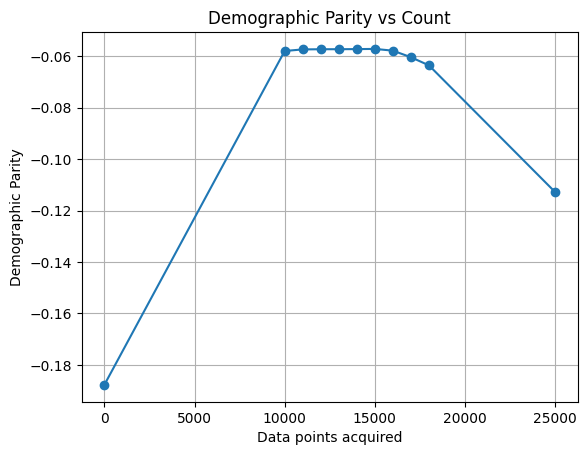

In [137]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [140]:
counts_to_check = [15000, 15100, 15200, 15300, 15400, 15500, 15600, 15700, 15800, 15900, 16000]

x_train_a = np.copy(X_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

# dp[0] = dp_ori

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [X_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, X_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 15000 data points: {15000: -0.05714793355923567}
Demographic Parity for first 15100 data points: {15000: -0.05714793355923567, 15100: -0.0572134109238131}
Demographic Parity for first 15200 data points: {15000: -0.05714793355923567, 15100: -0.0572134109238131, 15200: -0.05724474842926078}
Demographic Parity for first 15300 data points: {15000: -0.05714793355923567, 15100: -0.0572134109238131, 15200: -0.05724474842926078, 15300: -0.057240428406673816}
Demographic Parity for first 15400 data points: {15000: -0.05714793355923567, 15100: -0.0572134109238131, 15200: -0.05724474842926078, 15300: -0.057240428406673816, 15400: -0.057233608385857115}
Demographic Parity for first 15500 data points: {15000: -0.05714793355923567, 15100: -0.0572134109238131, 15200: -0.05724474842926078, 15300: -0.057240428406673816, 15400: -0.057233608385857115, 15500: -0.05723001483120424}
Demographic Parity for first 15600 data points: {15000: -0.05714793355923567, 15100: -0.057213410

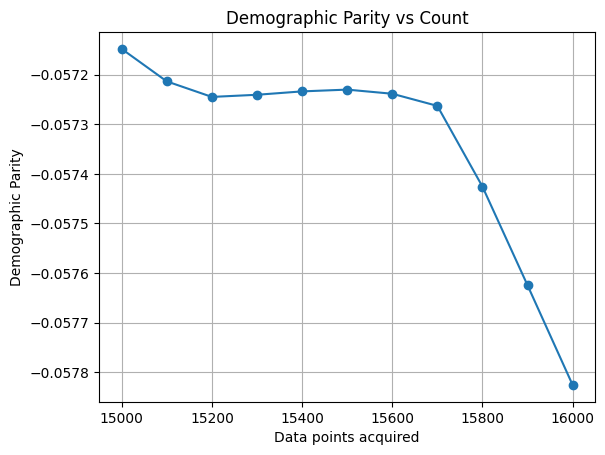

In [141]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [ ]:
#15200 datapoints can be acquired to decrease the demographic parity